In [1]:
import torch
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else "cpu"
device

'cuda'

In [3]:
df_origin = pd.read_csv("/content/Corona_NLP_train.csv",encoding='ISO-8859-1')

In [4]:
df_origin.shape

(41157, 6)

In [5]:
df_origin.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
df_origin = df_origin[['OriginalTweet','Sentiment']]

In [7]:
df_origin.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
df_origin.nunique()

OriginalTweet    41157
Sentiment            5
dtype: int64

In [9]:
df_origin.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [10]:
df_origin.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [11]:
df_origin['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

## Data Preprocessing

In [12]:
!python -m spacy download en_core_web_lg
import spacy
nlp = spacy.load('en_core_web_lg')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
import string
import re
stop_words = nlp.Defaults.stop_words
punctuations = string.punctuation

def text_preprocessing(text):
  doc = nlp(text)
  my_token = [word.lemma_.lower().strip() for word in doc]
  my_token = [word for word in my_token if word not in stop_words and word not in  punctuations]
  sentence = " ".join(my_token)
  return sentence

In [14]:
df_origin['cleaned_Tweets'] = df_origin['OriginalTweet'].apply(text_preprocessing)

In [15]:
labels = df_origin['Sentiment'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['Neutral', 'Positive', 'Extremely Negative', 'Negative', 'Extremely Positive']

In [16]:
NUM_Labels = len(labels)
id2label = {id:label for id,label in enumerate(labels)}
label2id = {label:id for id,label in enumerate(labels)}

In [17]:
id2label

{0: 'Neutral',
 1: 'Positive',
 2: 'Extremely Negative',
 3: 'Negative',
 4: 'Extremely Positive'}

In [18]:
label2id

{'Neutral': 0,
 'Positive': 1,
 'Extremely Negative': 2,
 'Negative': 3,
 'Extremely Positive': 4}

In [19]:
df_origin['labels'] = df_origin.Sentiment.map(lambda x : label2id[x.strip()])

In [20]:
df_origin.head()

,OriginalTweet,Sentiment,cleaned_Tweets,labels
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,@menyrbie @phil_gahan @chrisitv https://t.co/i...,0
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...,1
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth elderly disabl...,1
3,My food stock is not the only one which is emp...,Positive,food stock ... panic food need stay calm stay ...,1
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready supermarket covid19 outbreak paranoid fo...,2


<Axes: >

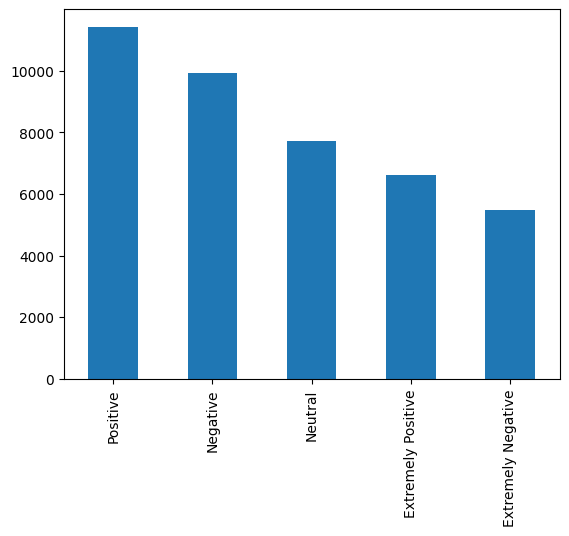

In [21]:
df_origin.Sentiment.value_counts().plot(kind = 'bar')


## Load bert model and Tokenizer

In [22]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [23]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels= NUM_Labels,id2label = id2label, label2id = label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [38]:
SIZE =df_origin.shape[0]
train_text = list(df_origin['cleaned_Tweets'][:SIZE//2])
val_texts = list(df_origin['cleaned_Tweets'][SIZE//2:(3*SIZE)//4])
test_texts = list(df_origin['cleaned_Tweets'][3*SIZE//4:])
train_labels = list(df_origin['labels'][:SIZE//2])
val_labels = list(df_origin['labels'][SIZE//2:(3*SIZE)//4])
test_labels = list(df_origin['labels'][3*SIZE//4:])



In [39]:
len(train_text),len(val_texts),len(test_texts)

(20578, 10289, 10290)

In [40]:
Encoding_train = tokenizer(train_text,truncation=True,padding=True)
Encoding_Val = tokenizer(val_texts,truncation=True,padding=True)
Encoding_test = tokenizer(test_texts,truncation=True,padding=True)

In [41]:
Encoding_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [42]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self,encodings,labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self,idx):
    item = {key : torch.tensor(val[idx]) for key, val in self.encodings.items()}
    if self.labels:
      item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.encodings['input_ids'])

In [58]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import numpy as np


In [70]:
def compute_metrics(p):
  labels = p.label_ids
  pred = p.predictions.argmax(-1)

  precision,recall,f1,_ = precision_recall_fscore_support(labels,pred,average='macro')
  accuracy = accuracy_score(labels, pred)


  return {
      'accuracy' : accuracy,
      'precision' : precision,
      'recall' : recall,
      'f1' : f1
  }

In [64]:
train_dataset = Dataset(Encoding_train, train_labels)
val_dataset  = Dataset(Encoding_Val, val_labels)
test_dataset = Dataset(Encoding_test, test_labels)

In [65]:
len(train_dataset)

20578

In [66]:
from transformers import TrainingArguments, Trainer

In [71]:
training_args =TrainingArguments(
    output_dir = 'output',
    do_train = True,
    do_eval = True,
    num_train_epochs= 3,
    per_device_train_batch_size= 16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy ="steps",
    logging_dir = 'class_logs',
    logging_steps = 50,
    evaluation_strategy='steps',
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end =True
)

In [72]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [73]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.688200,1.593754,0.339392,0.358229,0.338642,0.341333
100,1.487600,1.450726,0.358635,0.479139,0.383336,0.328691
150,1.329800,1.265688,0.449704,0.403506,0.433307,0.390096
200,1.172800,1.185661,0.480902,0.511415,0.534205,0.483930
250,1.141300,1.114544,0.521917,0.551903,0.535784,0.523460
300,1.145500,1.058189,0.551268,0.551652,0.596174,0.559370
350,1.094900,1.063816,0.555253,0.591069,0.578551,0.565451
400,1.044000,0.980064,0.613762,0.632186,0.629672,0.626941
450,1.044200,1.030937,0.560987,0.605624,0.586274,0.569304
500,1.065100,1.081426,0.535912,0.569098,0.591602,0.546216


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=3861, training_loss=0.730305844716722, metrics={'train_runtime': 2513.4865, 'train_samples_per_second': 24.561, 'train_steps_per_second': 1.536, 'total_flos': 4600163347649460.0, 'train_loss': 0.730305844716722, 'epoch': 3.0})

In [76]:
def predict(text):
  inputs = tokenizer(text,padding=True,truncation=True,max_length=512,return_tensors='pt').to('cuda')
  outputs= model(**inputs)

  probs = outputs[0].softmax(1)
  pred_label_idx = probs.argmax()
  pred_label = model.config.id2label[pred_label_idx.item()]
  return probs,pred_label_idx,pred_label

In [84]:
text = "TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1"
predict(text)

(tensor([[0.1540, 0.0875, 0.0315, 0.7241, 0.0028]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(3, device='cuda:0'),
 'Negative')

In [91]:
text = "HI TWITTER! I am a pharmacist. I sell hand sanitizer for a living! Or I do when any exists. Like masks, it is sold the fuck out everywhere. SHOULD YOU BE WORRIED? No. Use soap. SHOULD YOU VISIT TWENTY PHARMACIES LOOKING FOR THE LAST BOTTLE? No. Pharmacies are full of sick people."

In [92]:
predict(text)

(tensor([[0.0458, 0.1425, 0.2011, 0.5875, 0.0231]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(3, device='cuda:0'),
 'Negative')

In [93]:
model_path = "corona_twitte_classification-model"

In [94]:
trainer.save_model(model_path)

In [95]:
tokenizer.save_pretrained(model_path)

('corona_twitte_classification-model/tokenizer_config.json',
 'corona_twitte_classification-model/special_tokens_map.json',
 'corona_twitte_classification-model/vocab.txt',
 'corona_twitte_classification-model/added_tokens.json',
 'corona_twitte_classification-model/tokenizer.json')